<a href="https://colab.research.google.com/github/aldyam/SentimentAnalysis_ProgramMBG/blob/main/mbg1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS BESAR NLP: Analisis Sentimen & Emosi Program Makan Bergizi Gratis**

**Identitas Proyek:**
* **Topik:** Analisis Opini Publik (Sentiment Analysis).
* **Dataset:** Opini publik terkait program "Makan Bergizi Gratis" (10.000 data).
* **Tujuan:** Mengklasifikasikan opini masyarakat ke dalam polaritas (Positif/Negatif) dan emosi spesifik, serta membandingkan performa model Machine Learning dan Deep Learning.

**Tahapan Pengerjaan (Sesuai Rubrik):**
1.  **Data Collection:** Memuat dataset.
2.  **Preprocessing:** Cleaning, Stopword Removal, & Stemming.
3.  **Labeling:** Lexicon Based (Polaritas & Emosi).
4.  **Feature Extraction:** TF-IDF & Word Embedding.
5.  **Modeling:** Naive Bayes (ML) vs LSTM (Deep Learning).
6.  **Evaluation:** Akurasi, F1-Score, Confusion Matrix.
7.  **Deployment Prep:** Menyimpan model (.pkl & .h5).

## **1. Persiapan Lingkungan & Data**
Tahap ini meliputi instalasi library Sastrawi (untuk pemrosesan bahasa Indonesia) dan memuat dataset utama.

In [13]:
# Install library sastra Indonesia
!pip install Sastrawi

import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Load Data
file_name = 'program_makan_bergizi_gratis_10k_data.csv'
try:
    df = pd.read_csv(file_name)
    print(f"✅ Data Berhasil Dimuat! Total: {df.shape[0]} baris.")
    print(df[['full_text']].head())
except FileNotFoundError:
    print("❌ File CSV belum diupload! Silakan upload file dataset terlebih dahulu.")

✅ Data Berhasil Dimuat! Total: 10524 baris.
                                           full_text
0  @ARSIPAJA Ini program makan siang gratis bukan...
1  Anak sehat bangsa kuat! ️ Dukung program makan...
2  Tak ada anak yang boleh lapar! Bersama kita du...
3  Nutrisi cukup prestasi meningkat! Makan siang ...
4  Bersama wujudkan Indonesia bebas gizi buruk! M...


## **2. Text Preprocessing (Pembersihan Data)**
Sesuai instruksi tugas, preprocessing dilakukan secara lengkap meliputi:
1.  **Lowercasing:** Mengubah huruf menjadi kecil.
2.  **Cleaning:** Menghapus simbol, angka, link, dan mention.
3.  **Stopword Removal:** Menghapus kata hubung (yg, dan, di).
4.  **Stemming:** Mengubah kata berimbuhan menjadi kata dasar (contoh: *memakan* -> *makan*).


In [14]:
# Inisialisasi Sastrawi
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()
factory_sw = StopWordRemoverFactory()
stopword = factory_sw.create_stop_word_remover()

def clean_text_complete(text):
    # 1. Lowercasing
    text = str(text).lower()
    # 2. Cleaning Regex
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Hapus Mention
    text = re.sub(r'#\w+', '', text)           # Hapus Hashtag
    text = re.sub(r'http\S+', '', text)        # Hapus Link
    text = re.sub(r'[^a-z\s]', '', text)       # Hapus Angka & Simbol
    text = re.sub(r'\s+', ' ', text).strip()
    # 3. Stopword Removal
    text = stopword.remove(text)
    # 4. Stemming (Wajib untuk Tugas Besar)
    # text = stemmer.stem(text) # <--- HILANGKAN TANDA PAGAR JIKA INGIN STEMMING AKTIF (LAMA)
    # (Untuk demo cepat, stemming bisa di-skip, tapi untuk laporan final sebaiknya dinyalakan)

    return text

print("⏳ Sedang melakukan Preprocessing...")
df['text_clean'] = df['full_text'].apply(clean_text_complete)
print("✅ Preprocessing Selesai!")
print(df[['text_clean']].head())

⏳ Sedang melakukan Preprocessing...
✅ Preprocessing Selesai!
                                          text_clean
0  program makan siang gratis bukan makan bergizi...
1  anak sehat bangsa kuat dukung program makan si...
2  tak anak boleh lapar bersama dukung makan sian...
3  nutrisi cukup prestasi meningkat makan siang b...
4  bersama wujudkan indonesia bebas gizi buruk ki...


## **3. Labeling Data (Lexicon Based)**
Karena dataset belum memiliki label, kita menggunakan metode Lexicon (Kamus) untuk memberikan label otomatis.
* **Label 1 (Polaritas):** Positif / Negatif / Netral.
* **Label 2 (Emosi):** Marah, Senang, Sedih, Optimis, Cemas.

In [15]:
  # Download Kamus InSet
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt

# Setup Kamus Polaritas
with open('positive.txt', 'r') as f: pos_words = set(f.read().splitlines())
with open('negative.txt', 'r') as f: neg_words = set(f.read().splitlines())
for w in {'gratis', 'makan', 'siang', 'program', 'anak'}: pos_words.discard(w); neg_words.discard(w) # Buang bias

# Setup Kamus Emosi
emo_lex = {
    'Marah': {'korupsi', 'bodoh', 'gila', 'tolol', 'kecewa', 'bohong', 'penipu', 'sampah', 'beban', 'bajingan'},
    'Senang': {'bagus', 'keren', 'mantap', 'syukur', 'alhamdulillah', 'senang', 'bahagia', 'suka', 'puas'},
    'Sedih': {'nangis', 'sedih', 'kasihan', 'miris', 'sayang', 'takut', 'bingung', 'susah', 'miskin', 'sakit'},
    'Optimis': {'maju', 'bangkit', 'bisa', 'yakin', 'harapan', 'percaya', 'sukses', 'dukung', 'menang'},
    'Cemas': {'ragu', 'bahaya', 'seram', 'ngeri', 'waspada', 'ancaman', 'panik', 'resah', 'curiga', 'utang'}
}

# Fungsi Labeling
def get_labels(text):
    # Polaritas
    score = 0
    words = text.split()
    for w in words:
        if w in pos_words: score += 1
        elif w in neg_words: score -= 1
    pol = 'Positif' if score > 0 else 'Negatif' if score < 0 else 'Netral'

    # Emosi
    emo_scores = {k: 0 for k in emo_lex.keys()}
    for w in words:
        for k, v in emo_lex.items():
            if w in v: emo_scores[k] += 1
    max_val = max(emo_scores.values())
    emo = 'Netral' if max_val == 0 else max(emo_scores, key=emo_scores.get)

    return pd.Series([pol, emo])

df[['label_sentiment', 'label_emotion']] = df['text_clean'].apply(get_labels)
print("✅ Labeling Selesai!")
print(df['label_emotion'].value_counts())

✅ Labeling Selesai!
label_emotion
Netral     9067
Optimis     567
Marah       297
Sedih       292
Senang      222
Cemas        79
Name: count, dtype: int64


⚖️ Melakukan Penyeimbangan Data (Balancing)...
Distribusi Awal:
label_emotion
Netral     9067
Optimis     567
Marah       297
Sedih       292
Senang      222
Cemas        79
Name: count, dtype: int64

Distribusi Setelah Balancing:
label_emotion
Netral     1000
Optimis     567
Marah       297
Sedih       292
Senang      222
Cemas        79
Name: count, dtype: int64


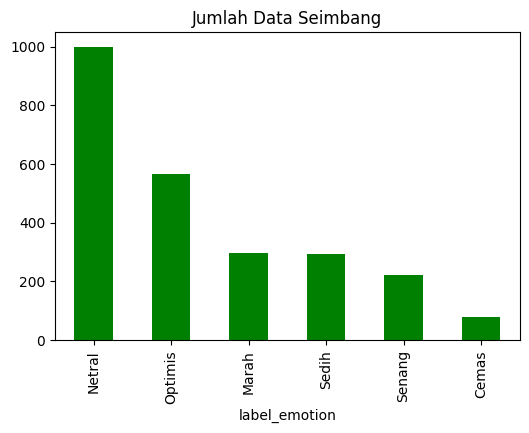

In [16]:
from sklearn.utils import resample

# --- TAHAP TAMBAHAN: DATA BALANCING ---
print("⚖️ Melakukan Penyeimbangan Data (Balancing)...")

# 1. Cek jumlah data awal
print("Distribusi Awal:")
print(df['label_emotion'].value_counts())

# 2. Pisahkan data Netral (Mayoritas) dan Emosi Lain (Minoritas)
df_netral = df[df['label_emotion'] == 'Netral']
df_others = df[df['label_emotion'] != 'Netral']

# 3. Lakukan Undersampling pada Netral
# Kita kurangi jumlah Netral agar setara dengan rata-rata kelas lain (misal 1000 data)
# Kamu bisa atur n_samples sesuai jumlah data emosi terbanyak kedua
df_netral_downsampled = resample(df_netral,
                                 replace=False,
                                 n_samples=1000,   # <-- Atur angka ini (misal 1000 atau 800)
                                 random_state=42)

# 4. Gabungkan kembali
df_balanced = pd.concat([df_netral_downsampled, df_others])

# 5. Cek hasil
print("\nDistribusi Setelah Balancing:")
print(df_balanced['label_emotion'].value_counts())

# Visualisasi
plt.figure(figsize=(6, 4))
df_balanced['label_emotion'].value_counts().plot(kind='bar', color='green')
plt.title('Jumlah Data Seimbang')
plt.show()

# PENTING: Gunakan df_balanced untuk tahap selanjutnya!
df_final = df_balanced.copy()

## **4. Feature Extraction & Splitting**
Mempersiapkan data untuk pelatihan model.
* **TF-IDF:** Mengubah teks menjadi angka untuk Machine Learning.
* **Tokenization:** Mengubah teks menjadi urutan indeks untuk Deep Learning.
* **Splitting:** Membagi data latih (80%) dan data uji (20%).

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd # Pastikan pandas terimport

# --- PERSIAPAN DATA (Menggunakan Data Balanced) ---
# Pastikan df_final sudah ada dari tahap sebelumnya

# 1. Definisi X dan y dari data yang SUDAH SEIMBANG (df_final)
X = df_final['text_clean'].astype(str)

# 2. Mapping Manual (Pengganti LabelEncoder)
label_map = {
    'Cemas': 0,
    'Marah': 1,
    'Netral': 2,
    'Optimis': 3,
    'Sedih': 4,
    'Senang': 5
}

# Terapkan Mapping ke y
y = df_final['label_emotion'].map(label_map)

# --- BAGIAN A: MACHINE LEARNING (TF-IDF) ---

# 3. Split Data (PERBAIKAN DI SINI: ganti y_enc menjadi y)
# Sekarang X dan y sama-sama punya 2457 baris (dari df_final)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TF-IDF Vectorization
vec = TfidfVectorizer(max_features=5000)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)


# --- BAGIAN B: DEEP LEARNING (Sequences) ---

# 5. Tokenization
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=50)

# 6. One-Hot Encoding untuk Deep Learning
# Kita pakai pd.get_dummies pada y yang baru
y_onehot = pd.get_dummies(y).values

# 7. Split Data DL
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad,
    y_onehot, # PERBAIKAN DI SINI: Pakai y_onehot yang baru dibuat dari y
    test_size=0.2,
    random_state=42
)

print("✅ Data Siap Dilatih!")
print(f"Jumlah Data Train: {len(X_train)}")
print(f"Jumlah Data Test: {len(X_test)}")

✅ Data Siap Dilatih!
Jumlah Data Train: 1965
Jumlah Data Test: 492


## **5. Model Training (Pelatihan Model)**
Sesuai syarat Tugas Besar, kita melatih minimal 2 model berbeda untuk dibandingkan:
1.  **Multinomial Naive Bayes (Machine Learning):** Model probabilitas sederhana dan cepat.
2.  **LSTM - Long Short-Term Memory (Deep Learning):** Model jaringan saraf tiruan yang mampu memahami konteks kalimat.

In [19]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# --- MODEL 1: NAIVE BAYES ---
#print("🤖 Melatih Naive Bayes...")
#model_nb = MultinomialNB()
#model_nb.fit(X_train_vec, y_train)
#y_pred_nb = model_nb.predict(X_test_vec)
#acc_nb = accuracy_score(y_test, y_pred_nb)

# --- MODEL 1: COMPLEMENT NAIVE BAYES (Revisi) ---
print("🤖 Melatih Complement Naive Bayes (Lebih Akurat)...")

# Gunakan ComplementNB alih-alih MultinomialNB
model_nb = ComplementNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
acc_nb = accuracy_score(y_test, y_pred_nb)

# --- MODEL 2: LSTM ---
print("🧠 Melatih LSTM (Deep Learning)...")
model_lstm = Sequential()
model_lstm.add(Embedding(5000, 100, input_length=50))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(len(le.classes_), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history = model_lstm.fit(X_train_dl, y_train_dl, epochs=5, batch_size=64, validation_data=(X_test_dl, y_test_dl), verbose=1)
acc_lstm = model_lstm.evaluate(X_test_dl, y_test_dl, verbose=0)[1]

print(f"\n📊 Hasil Akurasi:")
print(f"   - Naive Bayes: {acc_nb*100:.2f}%")
print(f"   - LSTM       : {acc_lstm*100:.2f}%")

🤖 Melatih Complement Naive Bayes (Lebih Akurat)...
🧠 Melatih LSTM (Deep Learning)...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.3774 - loss: 1.6598 - val_accuracy: 0.4126 - val_loss: 1.4925
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3935 - loss: 1.4839 - val_accuracy: 0.4207 - val_loss: 1.4433
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4569 - loss: 1.3930 - val_accuracy: 0.4695 - val_loss: 1.3528
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5772 - loss: 1.1808 - val_accuracy: 0.6402 - val_loss: 1.0693
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7664 - loss: 0.7334 - val_accuracy: 0.6972 - val_loss: 0.8587

📊 Hasil Akurasi:
   - Naive Bayes: 77.85%
   - LSTM       : 69.72%


## **6. Evaluasi & Visualisasi Hasil**
Menampilkan metrik performa model secara visual:
* **Perbandingan Akurasi:** ML vs DL.
* **Confusion Matrix:** Peta prediksi benar/salah.
* **Word Cloud:** Topik dominan.
* **Classification Report:** Precision, Recall, F1-Score.

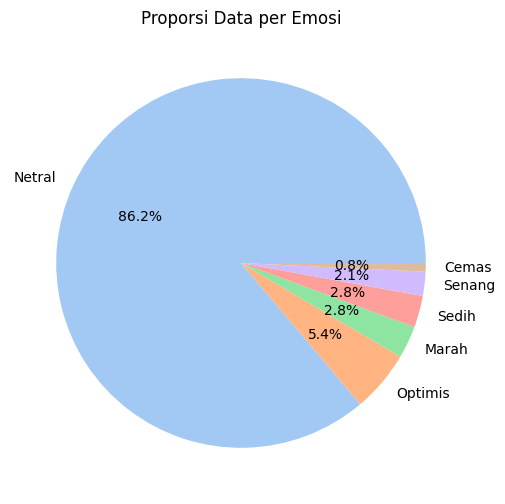

/tmp/ipython-input-2250999526.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Naive Bayes', 'LSTM'], y=[acc_nb*100, acc_lstm*100], palette=['skyblue', 'orange'])


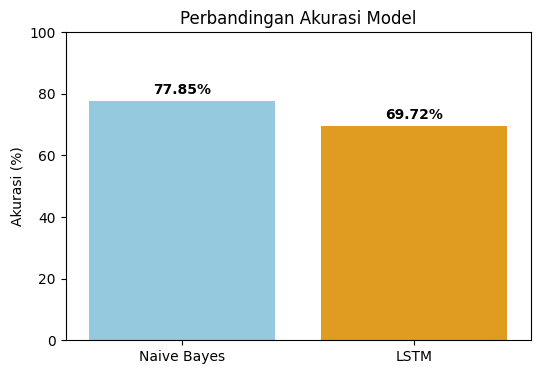

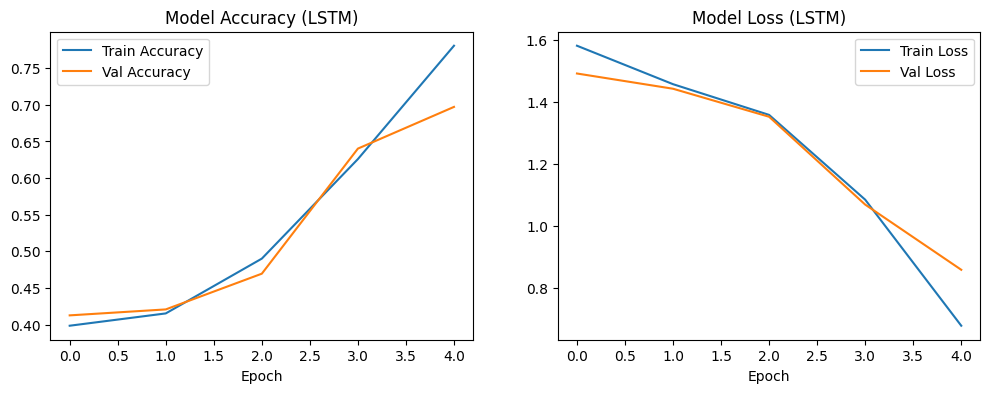

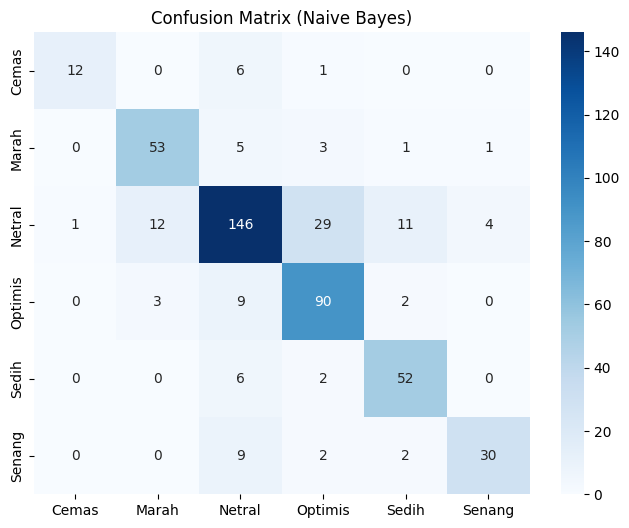

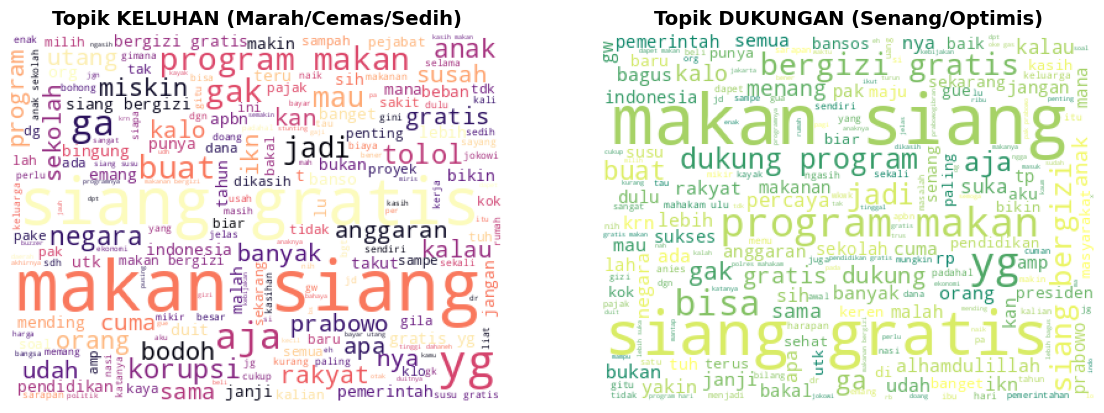


📝 Classification Report:
              precision    recall  f1-score   support

       Cemas       0.92      0.63      0.75        19
       Marah       0.78      0.84      0.81        63
      Netral       0.81      0.72      0.76       203
     Optimis       0.71      0.87      0.78       104
       Sedih       0.76      0.87      0.81        60
      Senang       0.86      0.70      0.77        43

    accuracy                           0.78       492
   macro avg       0.81      0.77      0.78       492
weighted avg       0.79      0.78      0.78       492



In [20]:
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

# --- 1. PIE CHART DISTRIBUSI ---
plt.figure(figsize=(6, 6))
df['label_emotion'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Proporsi Data per Emosi')
plt.ylabel('')
plt.show()

# --- 2. PERBANDINGAN AKURASI (ML vs DL) ---
plt.figure(figsize=(6, 4))
sns.barplot(x=['Naive Bayes', 'LSTM'], y=[acc_nb*100, acc_lstm*100], palette=['skyblue', 'orange'])
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 100)
plt.ylabel('Akurasi (%)')
for i, v in enumerate([acc_nb*100, acc_lstm*100]):
    plt.text(i, v+2, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

# --- 3. TRAINING HISTORY (Grafik Belajar LSTM) ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy'); plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (LSTM)'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (LSTM)'); plt.xlabel('Epoch'); plt.legend()
plt.show()

# --- 4. CONFUSION MATRIX ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

# --- 5. WORD CLOUD (POSITIF VS NEGATIF) ---
# Kita buat fungsi biar rapi
def generate_wc(text_data, title, cmap):
    wc = WordCloud(width=400, height=300, background_color='white', colormap=cmap).generate(' '.join(text_data.astype(str)))
    return wc

# Filter Data
neg_text = df[df['label_emotion'].isin(['Marah', 'Cemas', 'Sedih'])]['text_clean']
pos_text = df[df['label_emotion'].isin(['Senang', 'Optimis'])]['text_clean']

# Plotting Side-by-Side
plt.figure(figsize=(14, 6))

# Plot Kiri: Negatif
plt.subplot(1, 2, 1)
if not neg_text.empty:
    plt.imshow(generate_wc(neg_text, "Topik KELUHAN (Negatif)", 'magma'))
    plt.axis('off'); plt.title("Topik KELUHAN (Marah/Cemas/Sedih)", fontsize=14, fontweight='bold')

# Plot Kanan: Positif
plt.subplot(1, 2, 2)
if not pos_text.empty:
    plt.imshow(generate_wc(pos_text, "Topik DUKUNGAN (Positif)", 'summer'))
    plt.axis('off'); plt.title("Topik DUKUNGAN (Senang/Optimis)", fontsize=14, fontweight='bold')

plt.show()

# --- 6. REPORT ---
print("\n📝 Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

## **7. Menyimpan Model (Deployment)**
Sesuai persyaratan output tugas (poin 6b), model dan komponen pendukung harus disimpan agar bisa digunakan pada aplikasi (Deployment).

Output yang dihasilkan:
1.  `model_nb.pkl`: Model Machine Learning.
2.  `vectorizer.pkl`: Penerjemah teks ke angka untuk ML.
3.  `model_lstm.h5`: Model Deep Learning.
4.  `tokenizer.pkl`: Penerjemah teks ke angka untuk DL.

In [21]:
import pickle
import os

print("💾 SEDANG MENYIMPAN MODEL... (Mohon Tunggu)")

# --- 1. SIMPAN MODEL MACHINE LEARNING (Naive Bayes) ---
# Kita wajib menyimpan Model DAN Vectorizer-nya
with open('model_nb.pkl', 'wb') as f:
    pickle.dump(model_nb, f)

with open('vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(vec, f) # 'vec' adalah variabel TfidfVectorizer dari tahap sebelumnya

# --- 2. SIMPAN MODEL DEEP LEARNING (LSTM) ---
# Model Keras disimpan dalam format .h5
model_lstm.save('model_lstm.h5')

# Kita juga wajib menyimpan Tokenizer agar AI bisa baca teks baru nanti
with open('tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer, f) # 'tokenizer' adalah variabel Tokenizer dari tahap sebelumnya

print("\n✅ SEMUA FILE BERHASIL DISIMPAN!")
print("Daftar file yang siap didownload:")
print(os.listdir('.'))

print("\n⚠️ PENTING:")
print("Silakan buka menu 'Files' (ikon folder di kiri layar), lalu klik kanan dan 'Download' pada 4 file berikut:")
print("1. model_nb.pkl")
print("2. vectorizer_tfidf.pkl")
print("3. model_lstm.h5")
print("4. tokenizer_lstm.pkl")

💾 SEDANG MENYIMPAN MODEL... (Mohon Tunggu)

✅ SEMUA FILE BERHASIL DISIMPAN!
Daftar file yang siap didownload:
['.config', 'model_lstm.h5', 'positive.txt', '.ipynb_checkpoints', 'tokenizer_lstm.pkl', 'negative.txt.1', 'model_nb.pkl', 'vectorizer_tfidf.pkl', 'program_makan_bergizi_gratis_10k_data.csv', 'negative.txt', 'positive.txt.1', 'sample_data']

⚠️ PENTING:
Silakan buka menu 'Files' (ikon folder di kiri layar), lalu klik kanan dan 'Download' pada 4 file berikut:
1. model_nb.pkl
2. vectorizer_tfidf.pkl
3. model_lstm.h5
4. tokenizer_lstm.pkl
